### Домашнее задание

На основании функции по варианту необходимо:
1. Построить nn.Module, в котором вы определите `forward`и `my_forward_backward`
2. `forward` должен повторять функцию, выданную вам по варианту, `my_forward_backward` описывает проход по вычислителному графу, а также вычисление градиентов по этому графу с помощью backprop. Градиенты должны быть рассчитаны для параметров $w0, w1$, тензоры $x1, x2, x3$ считаются входными данными сети
3. Необходимо удалять неиспользуемые тензоры, как это делает Pytorch
4. Если какие-то узлы не нужны для вычисления результата, то вы не должны их вычислять в процессе backprop
5. Необходимо построить визуализацию вычислительного графа

Все материалы для выполнения задания можно найти в ноутбуках второго и третьего семинаров, а также в этом ноутбуке есть пример выполненного задания

In [ ]:
def v5():  # Тотмина Екатерина, Савушкина Алена
  r1 = x1 * w0 * x2 + w1 ** 2
  r2 = (x3 + w0 / w1) * (x1 ** 3 + x3 - x2)
  r3 = 1 - (x1 - x2) ** 2
  return (r1 - r3) * x3 * r2 / r1

In [16]:
import torch
import torch.nn as nn

class Graph(nn.Module):

    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor([0.950, 0.288], dtype=torch.float32))


    def forward(self, x1, x2, x3):
      w0, w1 = self.w[0], self.w[1]
      r1 = x1 * w0 * x2 + w1 ** 2
      r2 = (x3 + w0 / w1) * (x1 ** 3 + x3 - x2)
      r3 = 1 - (x1 - x2) ** 2
      return (r1 - r3) * x3 * r2 / r1


    def your_forward_backward(self, x1, x2, x3):
        w0, w1 = self.w[0], self.w[1]

        # forward
        a1 = x1 * w0 * x2
        a2 = w1 ** 2
        r1 = a1 + a2


        a3 = w0 / w1
        a4 = x3 + a3
        a5 = x1 ** 3
        a6 = a5 + x3 - x2
        r2 = a4 * a6

        a7 = x1 - x2
        r3 = 1 - a7 ** 2

        a8 = r1 - r3
        a9 = a8 * x3
        y = a9 * r2 / r1



        # Backward
        dy = 1.0  # начальный градиент из dy/dy

        da9 = dy * (r2 / r1) #  градиент y по a9 — это r2 / r1
        dr2 = dy * (a9 / r1) # градиент по r2 => dy / dr2= a9 / r1 => dr2 = dy * a9 / r1
        dr1 = dy * (-a9 * r2 / r1 ** 2) # dy / dr1 => произвожная для дроби => (v * du/dx * - u * dv/dx)/ v^2, u = a9 * r2 и v = r1

        da8 = da9 * x3 # da9 значем и a9 = a8 * x3 (из forward) => dy / da8 = dy / da8 * da9 / da8 => da8 / da9 = x3 => da8 = da9 * x3
        dx3 = da9 * a8 # также

        dr1 = dr1 + da8 # из a8 = r1 - r3 => dy / dr1 = dy / da8 * da8 / dr1 => da8 по r1 = 1, т.к. при изменении r1 на малое значение a8 изменится на такое же малое значение
        dr3 = -da8 # также

        # Backpropagation for r1 and r2
        da1 = dr1 # из r1 = a1 + a2 - прямая зависмость
        da2 = dr1 # также

        dw1 = da2 * 2 * w1 # из a2 = w1 ** 2 =>  dw1 / da2 = w1 * 2 => dw1 = da2 * w1 * 2
        dw0 = da1 * x1 * x2 # из a1 = x1 * w0 * x2 => da1 / dw0 = x1 * x2 => dy / dw0 = dy / da1 * da1 / dw0 (= x1 * x2) => dw0 = da1 * x1 * x2

        da4 = dr2 * a6 # из r2 = a4 * a6 => dr2 / da4 = a6 => dy / da4 = dy / dr2 (= dr2) * dr2 / da4 (= a6)
        da6 = dr2 * a4 # из r2 = a4 * a6 => dr2 / da6  = a4 => dy / da6 = dy / dr2 * dr2 / da6 => da6 = dr2 * a6

        da3 = da4 # из a4 = x3 + a3
        dx3 = dx3 + da4 # из a4 = x3 + a3 => da4 / dx3 = 1 (изменение на мал. величину) => dy / dx3 = dy / da4 * da4 / dx3
        dx2 = -da6 # из a5 + x3 - x2 => из a6 = a5 + x3 - x2 => da6 / dx2 = -1 (т.к. - x2) => dx2 = da6 * (da6 / dx2 = -1) => dx2 = -dx6
        dx1 = da6 * 3 * x1 ** 2 + dw0 * x2 # a6 = a5 + x3 - x2 (a5 = x1 ** 3) => a6 = x1 ** 3 + x3 - x2 => 1) da6 / dx1 = 3 * x1**2 =>
                                           # 2) (из a1 = x1 * w0 * x2) => dx1 / dw0 = dw0 * x2

        dw0 = dw0 + da3 / w1 # из a3 = w0 / w1 => da3 / dw0 = 1/w1 = > dw0 = da3 * 1/w1
        dw1 = dw1 - da3 * (w0 / w1 ** 2) # из a3 = w0 / w1 => da3 / dw1 = - w0 / w1**2 => dw1 = da3 * (- w0 / w1**2)

        # Set gradients
        self.w.grad = torch.stack([dw0, dw1])

        return y

In [12]:
from torchviz import make_dot

def test_model_class(model_class):
    model = model_class()

    for _ in range(10):
        x1, x2, x3 = torch.rand(3, requires_grad=True)


        model.zero_grad()
        y_torch = model(x1, x2, x3)
        y_torch.backward()
        grad_torch = model.w.grad.clone()


        print("y_torch:", y_torch.clone().detach().numpy(), "grad_torch:", grad_torch.clone().numpy())

        model.zero_grad()
        y_manual = model.your_forward_backward(x1, x2, x3)
        y_manual.backward()
        grad_manual = model.w.grad.clone()

        if _ == 0:
            graph = make_dot(y_manual, params=dict(model.named_parameters()))
            graph.render("your_forward_backward_graph", format="png")

        print("y_manual:", y_manual.clone().detach().numpy(), "grad_manual:", grad_manual.clone().numpy())
        print()

        assert torch.allclose(y_manual, y_torch, rtol=5e-05, atol=1e-7)
        assert torch.allclose(grad_manual, grad_torch, rtol=5e-05, atol=1e-7)

    print('Tests completed successfully!')


In [13]:
# Здесь тестируется построенная вами модель
test_model_class(Graph)

y_torch: -0.42820552 grad_torch: [-0.39109185  4.481759  ]
y_manual: -0.42820552 grad_manual: [-0.39109185  4.481759  ]

y_torch: -0.08138846 grad_torch: [1.7572691 1.3755718]
y_manual: -0.08138846 grad_manual: [1.7572691 1.3755718]

y_torch: -0.07449672 grad_torch: [0.19172138 0.45134887]
y_manual: -0.07449672 grad_manual: [0.19172138 0.45134887]

y_torch: -0.038486276 grad_torch: [-0.02221527  0.3506849 ]
y_manual: -0.038486276 grad_manual: [-0.02221527  0.3506849 ]

y_torch: 0.195369 grad_torch: [-0.17045195 -1.1076045 ]
y_manual: 0.195369 grad_manual: [-0.17045195 -1.1076045 ]

y_torch: 0.659687 grad_torch: [ 0.46559185 -6.0985255 ]
y_manual: 0.659687 grad_manual: [ 0.46559185 -6.0985255 ]

y_torch: 0.0061251405 grad_torch: [ 0.00635198 -0.06719714]
y_manual: 0.0061251405 grad_manual: [ 0.00635198 -0.06719714]

y_torch: 0.9597776 grad_torch: [  0.7716136 -10.964411 ]
y_manual: 0.9597776 grad_manual: [  0.7716136 -10.964411 ]

y_torch: -1.2391459 grad_torch: [0.30371642 7.0716105 ]


In [ ]:
# А сюда вы должны вставить визуализацию графа

In [8]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=2ca8a5cf36d81de5d9d783ae848fc17a43b7f2192cbb2754b3dbff11a750c641
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [11]:
from torchviz import make_dot

In [23]:
import torch
from torchviz import make_dot

x1, x2, x3 = torch.tensor(0.5, requires_grad=True), torch.tensor(1.5, requires_grad=True), torch.tensor(2.0, requires_grad=True)
model = Graph()

# Forward
y = model.forward(x1, x2, x3)
forward_graph = make_dot(y, params=dict(model.named_parameters()))
forward_graph.render("forward_graph", format="png")

# Обратный проход
y.backward()

full_graph = make_dot(y, params=dict(model.named_parameters()))
full_graph.render("forward_backward_same", format="png")


'forward_backward_same.png'

## forward graph

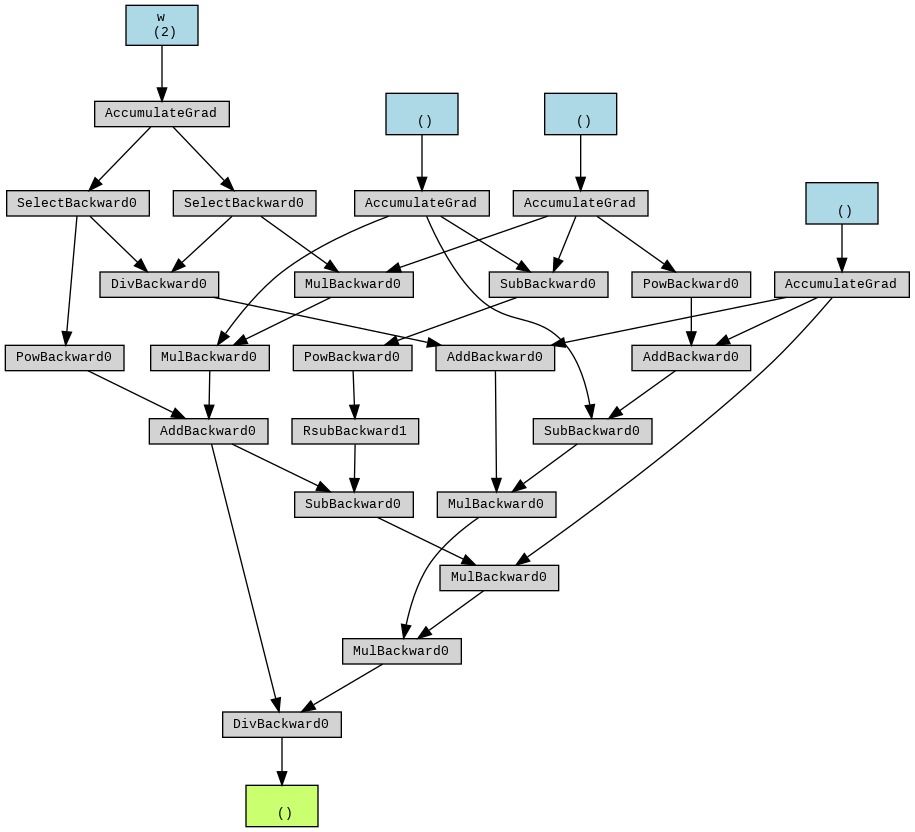

In [18]:
from IPython.display import Image
Image(filename="/content/forward_graph.png")

## backward graph

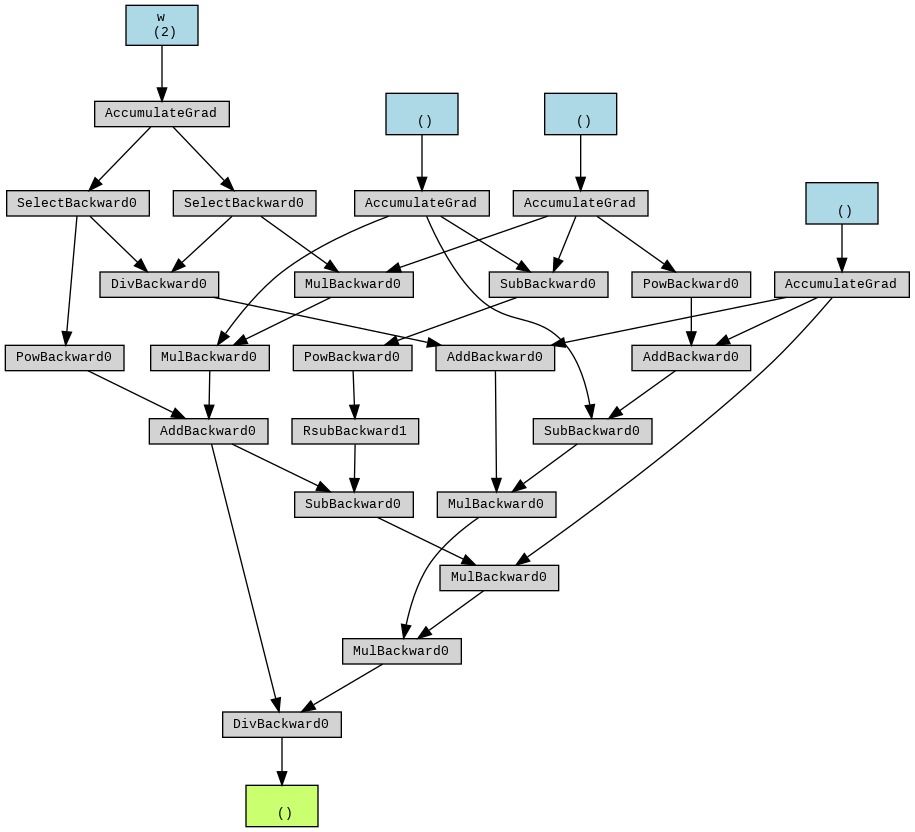

In [24]:
Image(filename="/content/forward_graph.png")